In [ ]:
import numpy as np
import torch

# Tensor

### Construct From Size

In [ ]:
torch.empty(5,3)

In [ ]:
torch.rand(5, 3)

In [ ]:
torch.zeros(5, 3, dtype=torch.long)

### Constuct from Data

In [ ]:
x = torch.tensor([5.5, 3])
x

### Create base on exisiting tensor
- properties will reuse unless provided
    - eg: dtype

- .new_*()
- torch.randn_like()

In [ ]:
x.new_ones(5, 3, dtype=torch.double)

In [ ]:
torch.randn_like(x, dtype=torch.float)  

# Operation

In [ ]:
x = torch.rand(5,3)
x
y = torch.rand(5,3)
y

In [ ]:
x + y

In [ ]:
torch.add(x,y)

In [ ]:
# in-place, operation wiht post-fixes '_'
x.add_(y)
x

In [ ]:
%timeit x+y
%timeit torch.add(x,y)
%timeit x.add(y)
%timeit x.add_(y)

## Resizing
- .view()

In [ ]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8) # the size -1 is inferred from other dimensions
z = x.view(-1, 4, 2)  
print(x.size(), y.size(), z.size())

For **one element** tensor  
can access the value by .item()

In [ ]:
x = torch.randn(1)
print(x)
print(x.item())

### Other operation
- 100+ operation [doc](https://pytorch.org/docs/stable/torch.html)
- transposing, indexing, slicing, math op, linear alg, rand, ... 


### Numpy Bridge
- on CPU
- tensor -> numpy
    - t.numpy()
- numpy -> tensor
    - torch.from_numpy(np)

In [ ]:
a = torch.ones(5)
print(a)
b = a.numpy()
print(b)

# both value will be same
a.add_(1)
print(a)
print(b)

In [ ]:
## numpy to torch tensor
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

### CUDA Tensor


In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.FloatTensor([1.])

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!
else:
    print("No cuda available")

# AUTOGRAD
- automatic differenctiation
- `autograd` package provides automatic differentiation for all operations on Tensors.

- when set `required_grad` as `True`
- all the oprtation on it will be tracked
- you can call `.backward()` to have all the gradient computed automatically
- gradient will be accumulated into `.grad` attribute


to stop tracking
- save memory usage
- `.detach()`
- or wrape the code block in `wit tourch.no_grad():`
- useful when we evaluating the model
    - dont needt to gradient
   
`Function` class
- each tensor has a `.grad_fn` that references a `Function` that has created the `Tensor`
- `grad_fn` is `None` for self define Tensor

Compute the derivatives
- `.backward()` on `Tensor`
- need to specify a `gradient` argument is the tensor is not One elemene data

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

In [ ]:
y = x + 2
print(y)

In [ ]:
print(y.grad_fn)

In [ ]:
z = y * y * 3
print(z)
out = z.mean()
print(out)

In [ ]:
## on/off requires_grad

a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a)

b = (a * a).sum()
print("Grad_fn :", b.grad_fn)

print(a.requires_grad)

a.requires_grad_(True)
print(a.requires_grad)

b = (a * a).sum()
print("Grad_fn :", b.grad_fn)

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

In [ ]:
x.grad, y.grad, z.grad, out.grad

In [ ]:
# Gradient
print(out)
print(out.backward())
# print(out.backward(retain_graph=True))
# retain_graph to allow the gradient to be compute and accumulate again 
print(x.grad)

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

In [ ]:
print(out.backward(torch.tensor(2.)))
print(x.grad)

In [ ]:
x.grad, y.grad, z.grad, out.grad

In [ ]:
y.backward(torch.ones(2,2))

In [ ]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2
y

In [ ]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

In [ ]:
x.grad, y.grad

### Disable requires_grad

In [ ]:
print(x.requires_grad)
print((x ** 2).requires_grad)

In [ ]:
with torch.no_grad():
    print((x ** 2).requires_grad)

### Neural Networks
- `torch.nn`
- `nn.Module`
    - containes layes
    - methods `forward(input)`
    - return `output`


Model
1. layer with learnable parameters/weights
1. iterate over dataset / inputs
1. process input
1. compute loss
1. prapagate gradients
1. update weight `w = w - lr * gradient`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

just have to define the `forward` function  
`backward` function is automatically defined using `autograd`  

`net.parameters()`: return learnable parameters

In [ ]:
params = list(net.parameters())
print(len(params))
for i in range(len(params)):
    print(params[i].size())
# print(params[0].size())  # conv1's .weight

#### Fit input to model
- take in a batch
- input size: `nSamples x nChannels x Height x Width`
- so for simple input
    - size: 1x3xHxW
    - can do `input.unsqueeze(0)`

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

#### Gradient
- zero the gradinet buffers of all params
- backprops with random gradient

In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Loss Function 
- some loss function under nn package
- eg: `nn.MSELoss`

In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

In [ ]:
print(output)
print(target)

In [ ]:
((target - output) ** 2).mean()

```
input 
-> conv2d -> relu -> maxpool2d 
-> conv2d -> relu -> maxpool2d
      -> view 
      -> linear -> relu 
      -> linear -> relu 
      -> linear
      -> MSELoss
      -> loss
```

In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### Backprop
- when we call `loss.backward()`
- the whole graph is differentiated w.r.t the loss
- all Tensor with `reuires_grad=True` have their `.grad` accumulated with the gradient

- need to clear the existing gradients
    - else gradients will be accumulated to existing gradient
- check for the update weight


w.r.t: with respect to

In [ ]:
net.zero_grad() 
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


In [ ]:
net.conv1.bias

### Update Weights
- update rule
- SGD, Nesterov-SGD, Adam, RMSProp ...
- in package `touch.optim`

In [ ]:
params = list(net.parameters())
params[0].data[0]

In [ ]:
params[0].grad.data[0]

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [ ]:
params[0].data[0]

In [ ]:
-0.2949 + 0.0117 * learning_rate

### touch.optim

In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
print(params[0].data[0])
optimizer.step() ## Doing the update
print(params[0].grad.data[0])

## Traning A Classifier

- data
    - can load as numpy 
    - then convert to Tensor
    - image: Pillow, OpenCV
    - audio: scipy, librosa
    - text: python, Cython, NLTK, SpaCy
- pytorch have a package `torchvision` for vision
    - data loaders for common dataset
        - CIFAR10, MNIST ...
    - transformers for image
    - `torchvision.datasets`, `torch.utils.data.DataLoader`
       

### CIFAR10 - Classifier
1. load dataset
2. define Network
3. Loss Function
4. Train
5. Test / Evaluate

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Visualization 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

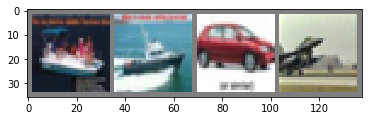

 ship  ship   car plane


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

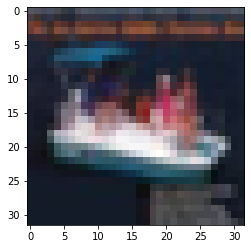

In [6]:
img = images[0]
img = img / 2 + 0.5
plt.imshow((np.transpose(img, (1, 2, 0))*255).numpy().astype('uint8'))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 

### Testing / Evaluation

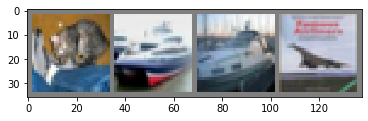

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
outputs = net(images)
outputs

tensor([[ 0.0826, -0.0366,  0.2558, -0.0434, -0.1072,  0.3884, -0.2344,  0.0025,
         -0.0121, -0.1067],
        [ 1.3316,  0.6727,  0.2755, -0.8525, -0.6871, -0.4992, -0.9080, -0.8257,
          1.5408,  1.1815],
        [ 1.3320,  0.5151,  0.1384, -0.6853, -0.6084, -0.2747, -0.8148, -0.6926,
          1.4620,  0.7718],
        [ 1.3159,  0.3726,  0.2286, -0.6421, -0.5587, -0.2720, -0.8089, -0.5995,
          1.3238,  0.6578]], grad_fn=<AddmmBackward>)

In [13]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([5, 8, 8, 8])

In [14]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship  ship


### Accuracy

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 22 %


### Evaluation

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [ ]:
class_correct

In [ ]:
class_total

In [ ]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### GPU

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

In [27]:
torch.cuda.device_count()

0

In [ ]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

In [ ]:
torch([1,1]).cuda()